## Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchsummary import summary

import matplotlib.pyplot as plt

from VisionTransformer import VisionTransformer

## Data Preprocessing

In [2]:
transform = ToTensor()
train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

In [3]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=256)
test_loader = DataLoader(test_set, shuffle=False, batch_size=256)

x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

## Define Model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = VisionTransformer(num_encoder_block=2, 
                          num_heads=4,
                          head_size=8,
                          n_classes=10,
                          hidden_dim=8, 
                          input_dims=(1,28,28), 
                          n_patches=7,
                          dropout=0.3).to(device)

In [9]:
summary(model, input=x);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            136
├─Embedding: 1-2                         400
├─PatchMaker: 1-3                        --
├─Sequential: 1-4                        --
|    └─Block: 2-1                        --
|    |    └─MultiHeadAttention: 3-1      1,128
|    |    └─FeedFoward: 3-2              552
|    |    └─LayerNorm: 3-3               16
|    |    └─LayerNorm: 3-4               16
|    └─Block: 2-2                        --
|    |    └─MultiHeadAttention: 3-5      1,128
|    |    └─FeedFoward: 3-6              552
|    |    └─LayerNorm: 3-7               16
|    |    └─LayerNorm: 3-8               16
├─Linear: 1-5                            90
Total params: 4,050
Trainable params: 4,050
Non-trainable params: 0


## Training

In [10]:
n_epoch = 10
lr_rate = 5e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

In [12]:
############ training loop
## save training loss & accuracy logs
train_epoch_logs, test_epoch_logs = [], []
train_epoch_acc_logs, test_epoch_acc_logs = [], []
## loop for epoch
for epoch in range(n_epoch):
    ## save epoch loss & accuracy
    train_epoch_loss = test_epoch_loss = 0
    train_epoch_acc = test_epoch_acc = 0
    ## set model to training mode
    model.train()
    ## loop for mini batches
    for n_batch, (x, y) in enumerate(train_loader):
        ## x, y = x.to(device), y.to(device)
        y_hat = model(x)
        ## calculate loss
        loss = loss_fn(y_hat, y)
        ## calculate gradients
        loss.backward()
        ## update weights
        optimizer.step()
        ## nullify gradients
        optimizer.zero_grad()
        ## save logs
        train_epoch_loss += loss.item()
        train_epoch_acc += (torch.argmax(F.softmax(y_hat, dim=-1), axis=1) == y).sum().item() / y_hat.shape[0]

    model.eval()
    with torch.no_grad():
        for n_batch, (x, y) in enumerate(test_loader):
            ## x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            test_epoch_loss += loss.item()
            test_epoch_acc += (torch.argmax(F.softmax(y_hat, dim=-1), axis=1) == y).sum().item() / y_hat.shape[0]
    
    ## update scheduler
    scheduler.step(train_epoch_loss/len(train_loader))
    ## save logs
    train_epoch_logs.append(train_epoch_loss/len(train_loader)) 
    test_epoch_logs.append(test_epoch_loss/len(test_loader))
    train_epoch_acc_logs.append(train_epoch_acc/len(train_loader))
    test_epoch_acc_logs.append(test_epoch_acc/len(test_loader))

    ## print intermediate results
    print(f'Epoch: {epoch+1} | Train Loss: {train_epoch_loss/len(train_loader):.4} | Train_acc: {train_epoch_acc/len(train_loader):.2} |\
 Val Loss: {test_epoch_loss/(len(test_loader)):.4} | Val Acc: {test_epoch_acc/len(test_loader):.2}')

Epoch: 1 | Train Loss: 1.585 | Train_acc: 0.41 | Val Loss: 0.7987 | Val Acc: 0.73
Epoch: 2 | Train Loss: 0.7884 | Train_acc: 0.73 | Val Loss: 0.5244 | Val Acc: 0.84
Epoch: 3 | Train Loss: 0.5794 | Train_acc: 0.81 | Val Loss: 0.3803 | Val Acc: 0.88
Epoch: 4 | Train Loss: 0.4856 | Train_acc: 0.84 | Val Loss: 0.3268 | Val Acc: 0.9
Epoch: 5 | Train Loss: 0.4327 | Train_acc: 0.86 | Val Loss: 0.2772 | Val Acc: 0.92
Epoch: 6 | Train Loss: 0.3948 | Train_acc: 0.88 | Val Loss: 0.2626 | Val Acc: 0.92
Epoch: 7 | Train Loss: 0.3598 | Train_acc: 0.89 | Val Loss: 0.2526 | Val Acc: 0.92
Epoch: 8 | Train Loss: 0.3456 | Train_acc: 0.89 | Val Loss: 0.2342 | Val Acc: 0.92
Epoch: 9 | Train Loss: 0.3283 | Train_acc: 0.9 | Val Loss: 0.2263 | Val Acc: 0.93
Epoch: 10 | Train Loss: 0.3129 | Train_acc: 0.9 | Val Loss: 0.2016 | Val Acc: 0.94


## Vizualization

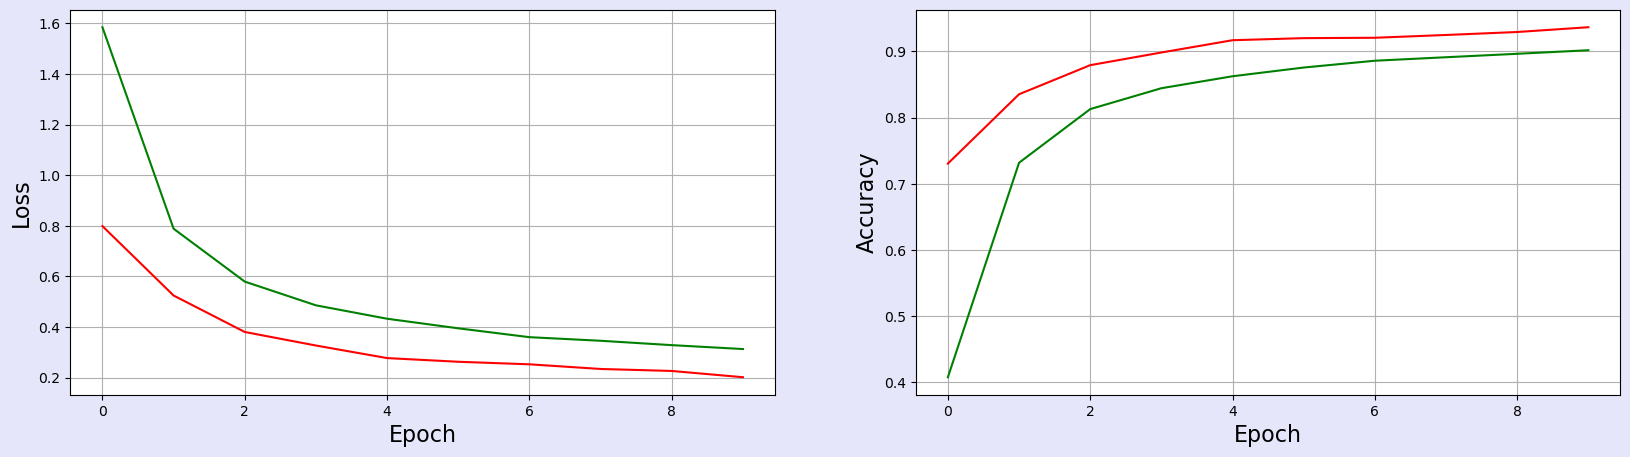

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20,5), facecolor="lavender")

ax[0].plot([*range(len(train_epoch_logs))], train_epoch_logs, color='green')
ax[0].plot([*range(len(test_epoch_logs))], test_epoch_logs, color='red')
ax[0].set_ylabel('Loss', size=16)
ax[0].set_xlabel('Epoch', size=16)
ax[0].grid()

ax[1].plot([*range(len(train_epoch_acc_logs))], train_epoch_acc_logs, color='green')
ax[1].plot([*range(len(test_epoch_acc_logs))], test_epoch_acc_logs, color='red')
ax[1].set_ylabel('Accuracy', size=16)
ax[1].set_xlabel('Epoch', size=16)
ax[1].grid()
plt.savefig("charts/raining_results.png", dpi=300);